## Train model for MNIST
**Function        : Train model in pytorch for MNIST **<br>
**Author          : Team DIANNA **<br>
**Contributor     : **<br>
**First Built     : 2021.06.06 **<br>
**Last Update     : 2021.06.06 **<br>
**Library         : os, numpy, matplotlib, torch, tensorflow, wandb **<br>
**Description     : In this notebook we train models in pytorch for (complete) MNIST dataset. The trained models will be used to explore the XAI methods later.**<br>
**Return Values   : pytorch models and training status (.pt) / training report from weights & biases**<br>

In [1]:
%matplotlib inline
import os
import time as tt
import numpy as np
# DL framework
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
#import torchvision
# for plotting
import matplotlib.pyplot as plt
# report and monitoring with Weights & Biases
import wandb

In [2]:
#################################################################################
#########                     path to the dataset                        ########
#################################################################################
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/mnist'
# please specify output path
output_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/train_models/mnist'
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok = True)

In [3]:
#################################################################################
#########                 extract MNIST dataset locally                  ########
#################################################################################
# pytorch will search its MNIST folder for the data, otherwise it will start downloading
# we can fool this downloader by placing our local mnist dataset in its path ("/path/MNIST/raw")
train_data_torch = torchvision.datasets.MNIST(datapath, train=True, download=True,
                                              transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor()]))
test_data_torch = torchvision.datasets.MNIST(datapath, train=False, download=True,
                                             transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor()]))
# batch size
batch_size_train = 64
batch_size_test = 1000
# MNIST dataset is handled by dataloader in pytorch
train_data_loader = torch.utils.data.DataLoader(train_data_torch,
                                                batch_size=batch_size_train, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_data_torch,
                                               batch_size=batch_size_test, shuffle=False)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Text(0.5, 1.0, 'Digit 5')

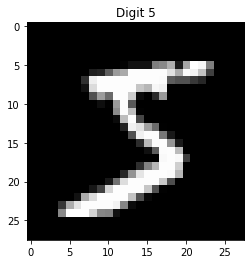

In [4]:
#################################################################################
#########                 precheck data from data loader                 ########
#################################################################################
train_X_y = enumerate(train_data_loader)
batch_idx, (train_X_torch, train_y_torch) = next(train_X_y)

# check the data
print(train_X_torch.shape)
print(train_y_torch.shape)

plt.imshow(train_X_torch[0,0,:,:], cmap='gray')
plt.title("Digit {}".format(train_y_torch[0]))

In [5]:
#################################################################################
#########              set up the environment for training               ########
#################################################################################
print ('*******************  check the version of pytorch  *********************')
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('*******************  login weights & biases  *********************')
# call weights & biases service
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
*******************  check the version of pytorch  *********************
Pytorch version 1.8.1
Is CUDA available? False
*******************  login weights & biases  *********************
wandb: Currently logged in as: git-yang (use `wandb login --relogin` to force relogin)


True

In [6]:
#################################################################################
#########                      build neural network                      ########
#################################################################################
class MnistNet(nn.Module):
    def __init__(self, kernels=[16, 32], dropout = 0.1, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(MnistNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc1 = nn.Linear(7 * 7 * kernels[-1], kernels[-1]) # pixel 28 / maxpooling 2 * 2 = 7
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [7]:
#################################################################################
#########            configure hyper-parameters & prepare data           ########
#################################################################################
hyperparameters = dict(
    epoch = 10,
    classes = 10,
    kernels = [16, 32],
    batch_size = batch_size_train,
    learning_rate = 0.001,
    dropout = 0.2,
    dataset = 'MNIST',
    architecture = 'CNN'
)

# initialize weights & biases service
#os.environ["WANDB_MODE"] = "offline"
wandb.init(config=hyperparameters, project='mnist standard', entity='dianna-ai')
config = wandb.config


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
#################################################################################
#########               create model and choose optimizer                ########
#################################################################################
model = MnistNet(config.kernels, config.dropout, config.classes)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss() # same as BCELoss(torch.sigmoid(x),...), but more numerically stable
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)

wandb.watch(model)

Model details:
 MnistNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=1568, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [9]:
#################################################################################
#########                   start the training process                   ########
#################################################################################
# calculate the time for the code execution
start_time = tt.time()
# switch model into train mode
model.train()

for epoch in range(config.epoch):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_data_loader):
        var_X_batch = torch.autograd.Variable(X_batch).float()
        var_y_batch = torch.autograd.Variable(y_batch).long()
        optimizer.zero_grad()
        output = model(var_X_batch).squeeze(1)
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        #predicted = torch.round(torch.sigmoid(output))
        correct += (predicted == var_y_batch).sum()
        #print(correct)
        wandb.log({'train_loss': loss.item(), 'train_acc': float(correct*100) / float(config.batch_size*(batch_idx+1))})
        if batch_idx % 50 == 0:
            print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                  epoch, batch_idx*len(X_batch), len(train_data_loader.dataset), 100.* batch_idx / len(train_data_loader),
                  loss.item(), float(correct*100) / float(config.batch_size*(batch_idx+1))))

# save the general checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, os.path.join(output_path,'mnistnet_training_checkpoint.pt'))

print ("--- %s minutes ---" % ((tt.time() - start_time)/60))

och : 8 [38912/60000 (65%)]	Loss: 0.052696	 Accuracy:97.919%
Epoch : 8 [39168/60000 (65%)]	Loss: 0.024960	 Accuracy:97.925%
Epoch : 8 [39424/60000 (66%)]	Loss: 0.106863	 Accuracy:97.913%
Epoch : 8 [39680/60000 (66%)]	Loss: 0.056845	 Accuracy:97.922%
Epoch : 8 [39936/60000 (67%)]	Loss: 0.042289	 Accuracy:97.925%
Epoch : 8 [40192/60000 (67%)]	Loss: 0.033776	 Accuracy:97.928%
Epoch : 8 [40448/60000 (67%)]	Loss: 0.064082	 Accuracy:97.927%
Epoch : 8 [40704/60000 (68%)]	Loss: 0.074187	 Accuracy:97.935%
Epoch : 8 [40960/60000 (68%)]	Loss: 0.030761	 Accuracy:97.938%
Epoch : 8 [41216/60000 (69%)]	Loss: 0.138117	 Accuracy:97.931%
Epoch : 8 [41472/60000 (69%)]	Loss: 0.049155	 Accuracy:97.920%
Epoch : 8 [41728/60000 (70%)]	Loss: 0.014267	 Accuracy:97.916%
Epoch : 8 [41984/60000 (70%)]	Loss: 0.082151	 Accuracy:97.910%
Epoch : 8 [42240/60000 (70%)]	Loss: 0.112163	 Accuracy:97.908%
Epoch : 8 [42496/60000 (71%)]	Loss: 0.060565	 Accuracy:97.909%
Epoch : 8 [42752/60000 (71%)]	Loss: 0.020450	 Accuracy:97

In [33]:
#################################################################################
#########                  start the evaluation process                  ########
#################################################################################
# switch model into evaluation mode
model.eval()
correct = 0
for batch_idx, (test_imgs, test_labels) in enumerate(test_data_loader):
    test_imgs = torch.autograd.Variable(test_imgs).float()
    output = model(test_imgs)
    predicted = torch.max(output,1)[1]
    #predicted = torch.round(torch.sigmoid(output))
    correct += (predicted == test_labels).sum()
    #print("Test accuracy:{:.3f}% ".format(float(correct) / (len(test_data_loader)*config.batch_size)))
    print("Test accuracy:{:.3f}% ".format(float(correct*100) / float(batch_size_test*(batch_idx+1))))
    wandb.log({'test_acc': float(correct*100) / float(config.batch_size*(batch_idx+1))})
    


Test accuracy:98.900% 
Test accuracy:98.750% 
Test accuracy:98.600% 
Test accuracy:98.750% 
Test accuracy:98.740% 
Test accuracy:98.900% 
Test accuracy:98.986% 
Test accuracy:99.100% 
Test accuracy:99.156% 
Test accuracy:99.140% 
